# Advanced Lane Finding
## Udacity Self-Driving Car Nanodegree
---

### Overview

The goal of this project is to write a software pipeline to indentify the lane
boundaries in a video with a front-facing camera on a car.  The camera<br>
calibration images, test road images, and project videos are available<br>
in this project repository:  https://github.com/udacity/CarND-Advanced-Lane-Lines

<br>
Below is a summary of the techniques used in this project.

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
5. Detect lane lines
6. Determine the lane curvature

---

In [1]:
# Imports
import pickle
import glob
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
# %matplotlib notebook  #  Enables interactive windows in jupyter notebook

# Undistort Function

In [2]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image        

# Read in each image
img = mpimg.imread('camera_cal/calibration1.jpg')
# Convert image to grayscale to use for gray.shape to get image dimensions
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
def get_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist, mtx, dist

# Compute the camera calibration matrix and distortion coefficients

In [3]:
#  Define name of a picle file
pickle_file = "wide_dist_pickle.p"
# Read in and make a list of calibration images
images = glob.glob('./camera_cal/*')


# If a pickel file exists, then load the file
if os.path.isfile(pickle_file):
    print("A pickle file exists")
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        mtx = pickle_data['mtx']
        dist = pickle_data['dist']
        objpoints = pickle_data['objpoints']
        imgpoints = pickle_data['imgpoints']

        del pickle_data  # Free up memory
# If not found, start calibrating using example images
else:
    # Arrays to store object points and image points from all the imgaes
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...., (7,5,0)
    nx = 9 # Number of inside corners of x
    ny = 6 # Number of inside corners of y

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:6].T.reshape(-1,2) # x, y coordinates

    for fname in images:
        # Read in each image
        img = mpimg.imread(fname)
        # Convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)


        # If corners are found, add object points, image points
        if ret == True:
            print(fname)
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
            plt.savefig('output_images/draw_corners/' + str(fname))
            plt.savefig('output_images/cornersDrawnOn.jpg')

    distorted_img = mpimg.imread('camera_cal/calibration1.jpg')
    # create mtx and dist from cal_undistort function
    dst, mtx, dist = get_undistort(distorted_img, objpoints, imgpoints)
    
    # Visualize
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(distorted_img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Save camera calibration result for later use in pickle file    
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    dist_pickle['objpoints'] = objpoints
    dist_pickle['imgpoints'] = imgpoints
    pickle.dump(dist_pickle, open(pickle_file, 'wb'))

A pickle file exists


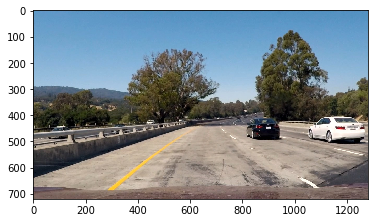

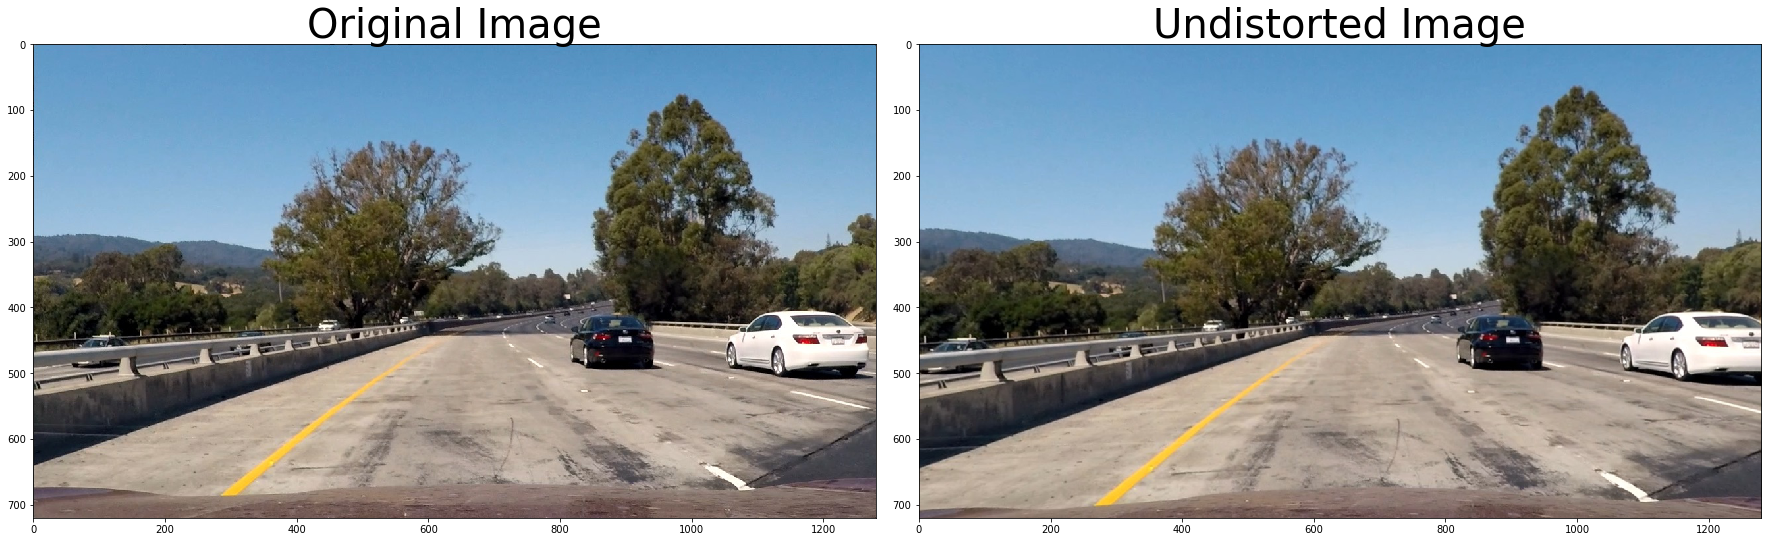

In [4]:
# Visualize with test
undist_test_image = mpimg.imread('test_images/test1.jpg')
undist_result_test, _, _ = get_undistort(undist_test_image, objpoints, imgpoints)
plt.imshow(undist_test_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_test_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist_result_test)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.savefig('output_images/undistorted_test_img.jpg')
plt.show()

# Combine Color and gradient thresholds for lane detection

In [5]:
def threshold(img, s_thresh=(125, 255), sx_thresh=(25, 255)):
    img = np.copy(img)

    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] =1
    
    return combined_binary

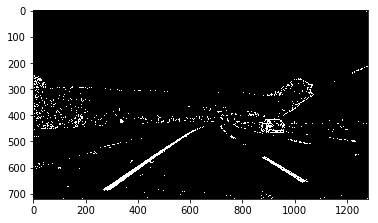

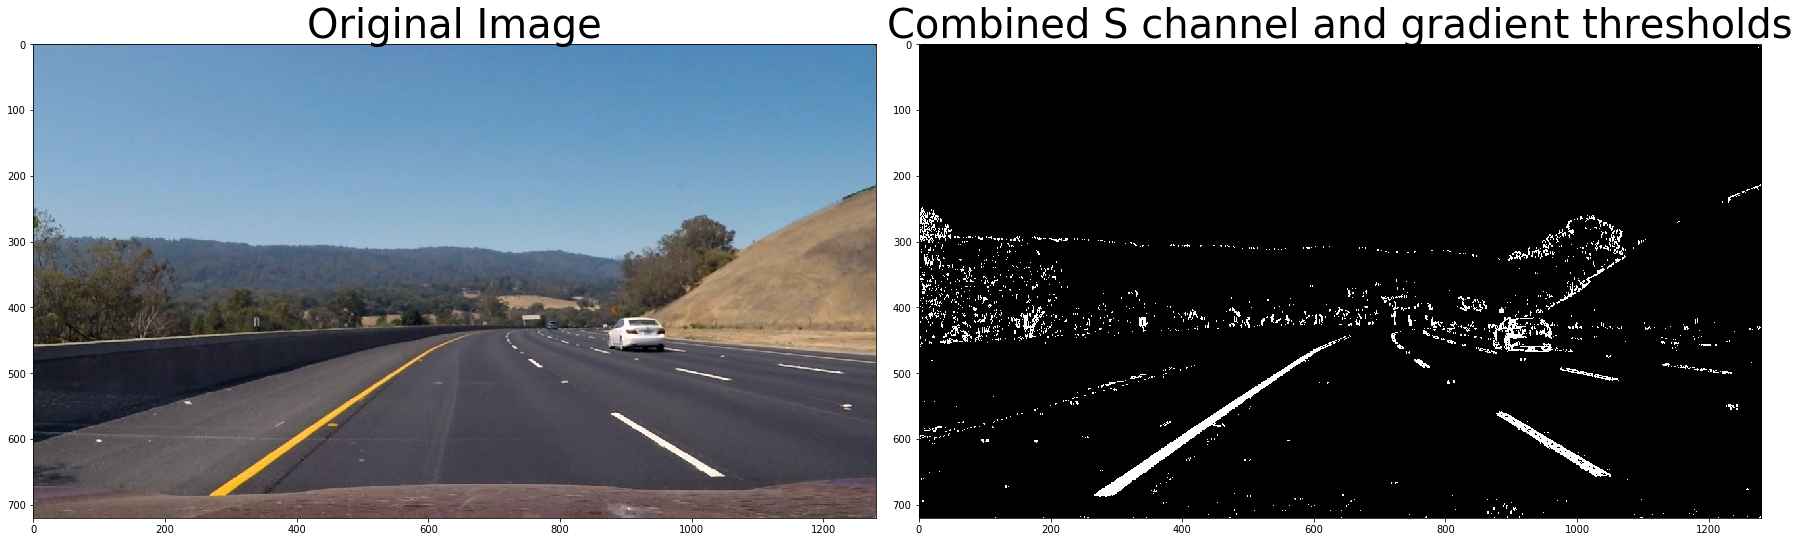

In [8]:
# Visualize with test
thresh_test_image = mpimg.imread('test_images/test3.jpg')
thresh_result_test = threshold(thresh_test_image)
plt.imshow(thresh_result_test, cmap = plt.get_cmap('gray'))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(thresh_test_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(thresh_result_test, cmap = plt.get_cmap('gray'))
ax2.set_title('Combined S channel and gradient thresholds', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.savefig('output_images/threshold.jpg')
plt.show()

# Perspective Transform

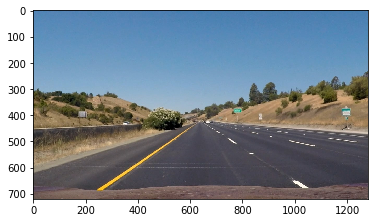

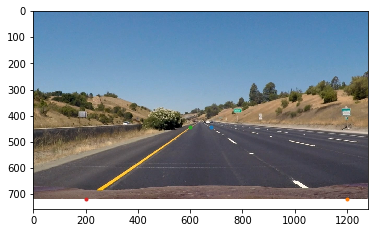

In [10]:
#read in and display original image
perspective_transform_img = mpimg.imread('test_images/straight_lines1.jpg')
plt.imshow(perspective_transform_img)
plt.show()

# Source image points
imshape = perspective_transform_img.shape
plt.imshow(perspective_transform_img)
plt.plot(681, 444, '.') # top right
plt.plot(1200, imshape[0], '.') # bottom right
plt.plot(598, 444, '.') # top left
plt.plot(200, imshape[0], '.') # bottom left
# plt.savefig('output_images/srcPointsPlotted.jpg')

In [6]:
# image for imshape
img_for_src_size = mpimg.imread('test_images/test1.jpg')
imshape = img_for_src_size.shape

# Four source coordinates
src = np.float32(
    [[681, 444],
     [1200, imshape[0]],
     [598, 444],
     [200, imshape[0]]])

# Four desired coordinates
dst = np.float32(
    [[975, (imshape[0] - imshape[0])],
     [975, imshape[0]],
     [300, (imshape[0] - imshape[0])],
     [300, imshape[0]]])

In [33]:
# Define perspective transform function
def warp(img):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the perspective transform inverse, Minv
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

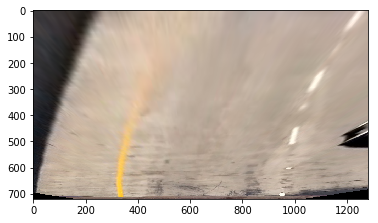

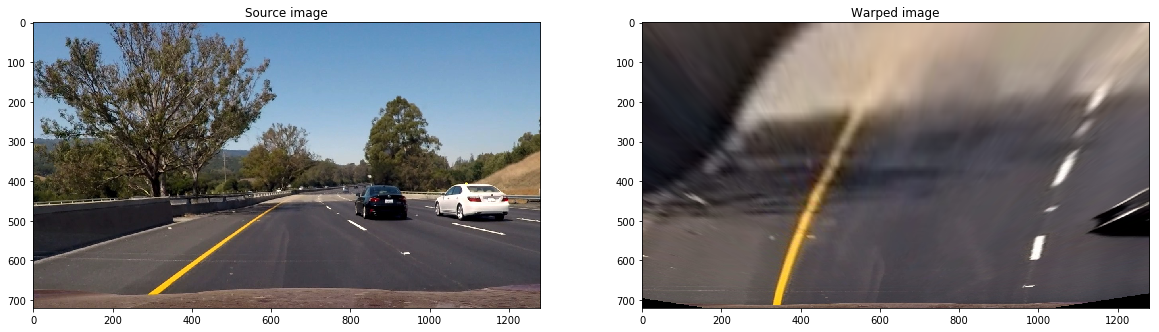

In [17]:
# Visualize with test
warped_im_test = warp(img_for_src_size)
plt.imshow(warped_im_test)

pers_test = mpimg.imread('test_images/test6.jpg')
warp_pers_test = warp(pers_test)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.set_title('Source image')
ax1.imshow(pers_test)
ax2.set_title('Warped image')
ax2.imshow(warp_pers_test)
# plt.savefig('output_images/perspectiveTransform.jpg')

# Polygonal Mask

In [8]:
# Image for image shape
img = (mpimg.imread('test_images/straight_lines2.jpg'))
imshape = img.shape

# Four vertices for image masking
vertices = np.array([[(100, imshape[0]),(560, 444),(720,444),(1200, imshape[0])]], dtype = np.int32)

In [9]:
def region_of_interest(img, vertices):
    # Define a blank mask to start with
    mask = np.zeros_like(img)
    
    # Define a 3 or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2] # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # Fill pixels inside the polygon defined by 'vertices' with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

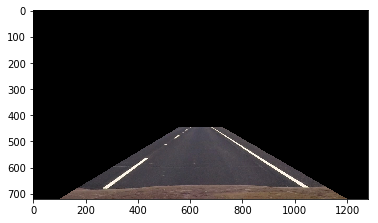

In [14]:
# Visualize with test

maskTest = region_of_interest(img, vertices)
plt.imshow(maskTest)

# Measuring Curvature

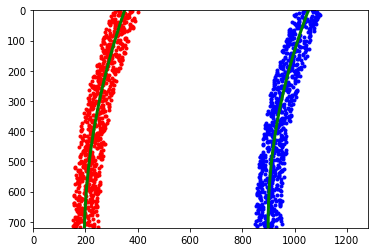

In [10]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [11]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1939.20043165 1606.97654216


In [12]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

636.205168844 m 527.73335463 m


# Class to receive the characteristics of each line detection

In [14]:
global left_lane 
global right_lane

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = np.zeros(720)
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.zeros(3)  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = np.zeros(1)
        #distance in meters of vehicle center from the line
        self.line_base_pos = np.zeros(1)
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #smoothen the n frames 
        self.smoothen_nframes = 10
        #first frame 
        self.first_frame = True
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
        
left_lane = Line()
right_lane = Line()

### Sliding_window_polyfit

In [15]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

###### Visualization 

ValueError: too many values to unpack (expected 2)

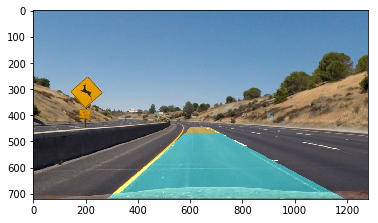

### Polyfit Using Fit from Previous Frame

In [16]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

# Find Lanes Function

In [45]:
def find_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    #check for any lanes that are not detected in this current frame then use the history
    if (leftx.size < 5):
        left_lane.detected = False
        #print ("Left lane deteceted - False")
    else:
        left_lane.detected = True
        #print ("Left lane detected - true")
    
    if (rightx.size < 5):
        right_lane.detected = False
        #print ("Right lane detected False")
    else:
        right_lane.detected = True
        #print ("Right lane detected True")
        
    #print (left_lane.detected, right_lane.detected)
    #if lane is detected then try to fit the poly
    if left_lane.detected == True & right_lane.detected == True:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_lane.best_fit = np.vstack([left_lane.best_fit,left_fit])
        left_lane.best_fit[0] = left_fit
        right_lane.best_fit = np.vstack([right_lane.best_fit,right_fit])
        right_lane.best_fit[0] = right_fit
        left_lane.best_fit = np.average(left_lane.best_fit[-left_lane.smoothen_nframes:], axis = 0)
        right_lane.best_fit = np.average(right_lane.best_fit[-right_lane.smoothen_nframes:], axis = 0)
        #print ("saved best fit")
    else: 
        #use the history avg values 
        left_fit = left_lane.best_fit
        right_fit = right_lane.best_fit
        #print ("used previous best fit")
    #calculate the actual points in x and y is from 0 to 719
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #print (left_lane.first_frame)
    #Take the average here of the last n frames   
    if left_lane.first_frame == True:
        left_lane.first_frame = False
        left_lane.bestx = np.vstack([left_lane.bestx,left_fitx])
        left_lane.bestx[0] = left_fitx
        #print ("Inside first frame")
    
    if ((left_fitx[0] > right_fitx[0]) | (abs(left_fitx[0] - right_fitx[0])<350) | (abs(left_fitx[0] - right_fitx[0])>700) | 
                   (left_fitx[0] > 800 )):
        left_lane.bestx = np.vstack([left_lane.bestx,left_lane.bestx])  
        #print ("Skip lane left")
    else:
        left_lane.bestx = np.vstack([left_lane.bestx,left_fitx])
        #print ("read lane left")
        
    left_lane.bestx = np.average(left_lane.bestx[-left_lane.smoothen_nframes:], axis = 0)
    
    if right_lane.first_frame == True:
        right_lane.first_frame = False
        right_lane.bestx = np.vstack([right_lane.bestx,right_fitx])
        right_lane.bestx[0] = right_fitx
        #print ("Inside first frame")
    
    if ((left_fitx[0] > right_fitx[0]) | (abs(left_fitx[0] - right_fitx[0])<350) | (abs(left_fitx[0] - right_fitx[0])>700) |
                      (right_fitx[0] > 1200)):
        right_lane.bestx = np.vstack([right_lane.bestx,right_lane.bestx])
        #print ("Skip lane right")
    else:
        right_lane.bestx = np.vstack([right_lane.bestx,right_fitx])
        #print ("read lane right")
    
    right_lane.bestx = np.average(right_lane.bestx[-right_lane.smoothen_nframes:], axis = 0)
    
    #print (left_lane.bestx[0])
    #print (left_fitx[0])
    #print (right_lane.bestx[0])
    #print (right_fitx[0])

    
    window_img = np.zeros_like(out_img)
    margin = 10
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 255]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 255]
    # Generate a polygon to illustrate the SMOOTHENED FIT
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_lane.bestx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_lane.bestx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_lane.bestx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
    
    # Generate a polygon to illustrate the CURRENT FRAME FIT
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,0, 255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
    
    #if the lane was detectded then calculate the curvatire or use the history
    if (leftx.size > 2 | rightx.size > 2) :
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters and dist from centre
        lane_centre = (left_fitx[-1] + right_fitx[-1])/2.0
        camera_centre = result.shape[1]/2.0

        dist_centre_val = (lane_centre - camera_centre)*3.7/700
        avg_cur = (right_curverad+left_curverad)/2.0
        
        left_lane.line_base_pos = np.vstack([left_lane.line_base_pos,dist_centre_val])
        left_lane.line_base_pos[0] = dist_centre_val
        left_lane.line_base_pos = np.average(left_lane.line_base_pos[-left_lane.smoothen_nframes:], axis = 0)
        
        left_lane.radius_of_curvature = np.vstack([left_lane.radius_of_curvature,avg_cur])
        left_lane.radius_of_curvature[0] = avg_cur
        left_lane.radius_of_curvature = np.average(left_lane.radius_of_curvature[-left_lane.smoothen_nframes:], axis = 0)
        
    #print (avg_cur, dist_centre_val)
    # else use the history curvature
    else:
        dist_centre_val = left_lane.line_base_pos
        avg_cur = left_lane.radius_of_curvature
    
    #reset the lane detected to false for the next frame 
    left_lane.detected == False
    right_lane.detected == False
    return result, left_lane.bestx, right_lane.bestx, ploty, left_lane.radius_of_curvature, left_lane.line_base_pos


# Draw Function

In [18]:
def draw_on_original(undist, left_fitx, right_fitx, ploty,Minv):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane with low confidence region in yellow ;)
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 204, 0))
    
    #confidence region in Green
    shift = 50
    diff = (right_fitx - left_fitx)/2
    pts_left = np.array([np.transpose(np.vstack([left_fitx[400:], ploty[400:]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx[400:], ploty[400:]])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 255))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.4, 0)
    plt.imshow(result)
    return result

### LAB B Channel

In [19]:
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

### HLS L Channel

In [20]:
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

### L+B Threshold

In [22]:
def l_b_threshold(img, sx_thresh=(20, 255)):
    img = np.copy(img)
    
    # Threshold color channel
#     l_binary = hls_lthresh(img)
    b_binary = lab_bthresh(img)

    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(l_binary), l_binary, b_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(l_binary)
    combined_binary[(b_binary == 1) | (sxbinary == 1)] =1
    
    return combined_binary

In [31]:
def _pipeline(img):
    # Undistort
    img_undistort = get_undistort(img, objpoints, imgpoints)
    
    threshold_img = l_b_threshold(img_undistort)
    
    # Perspective Transform
    img_unwarp = warp(threshold_img)

    return img_unwarp

In [41]:
def process_image(img):
    new_img = img.copy() #np.copy(img)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_bin = _pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out

# Software Pipeline

In [35]:
def pipeline(image):
    img = image.copy()
    undist, _, _ = get_undistort(img, objpoints, imgpoints)
    threshed = l_b_threshold(undist)
    masked = region_of_interest(threshed,vertices)
    perspective = warp(threshed)

    # Explicitly defining Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    # perspective = cv2.cvtColor(perspective, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    #pass the perspective image to the lane fitting stage
    slides_pers, left_fitx, right_fitx, ploty, avg_cur, dist_centre_val = find_lanes(perspective)
    #draw the detected lanes on the original image 
    mapped_lane = draw_on_original(undist, left_fitx, right_fitx, ploty, Minv)
    #font and text for drawing the offset and curvature 
    curvature = "Lane curvature %.2fm" % (avg_cur)
    dist_centre = "Offset from lane center %.2fm" % (dist_centre_val)
    font = cv2.FONT_HERSHEY_DUPLEX
    # using cv2 for drawing text/images in diagnostic pipeline.
    # else return the original mapped imaged with the curvature and offset drawn, in Google Colors!
    cv2.putText(mapped_lane, curvature, (30, 60), font, 1.2, (60,186,84), 2)
    cv2.putText(mapped_lane, dist_centre, (30, 120), font, 1.2, (244,194,13), 2)
    
    return mapped_lane



# Test Pipeline on Images

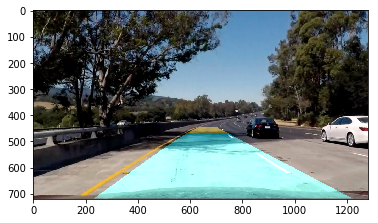

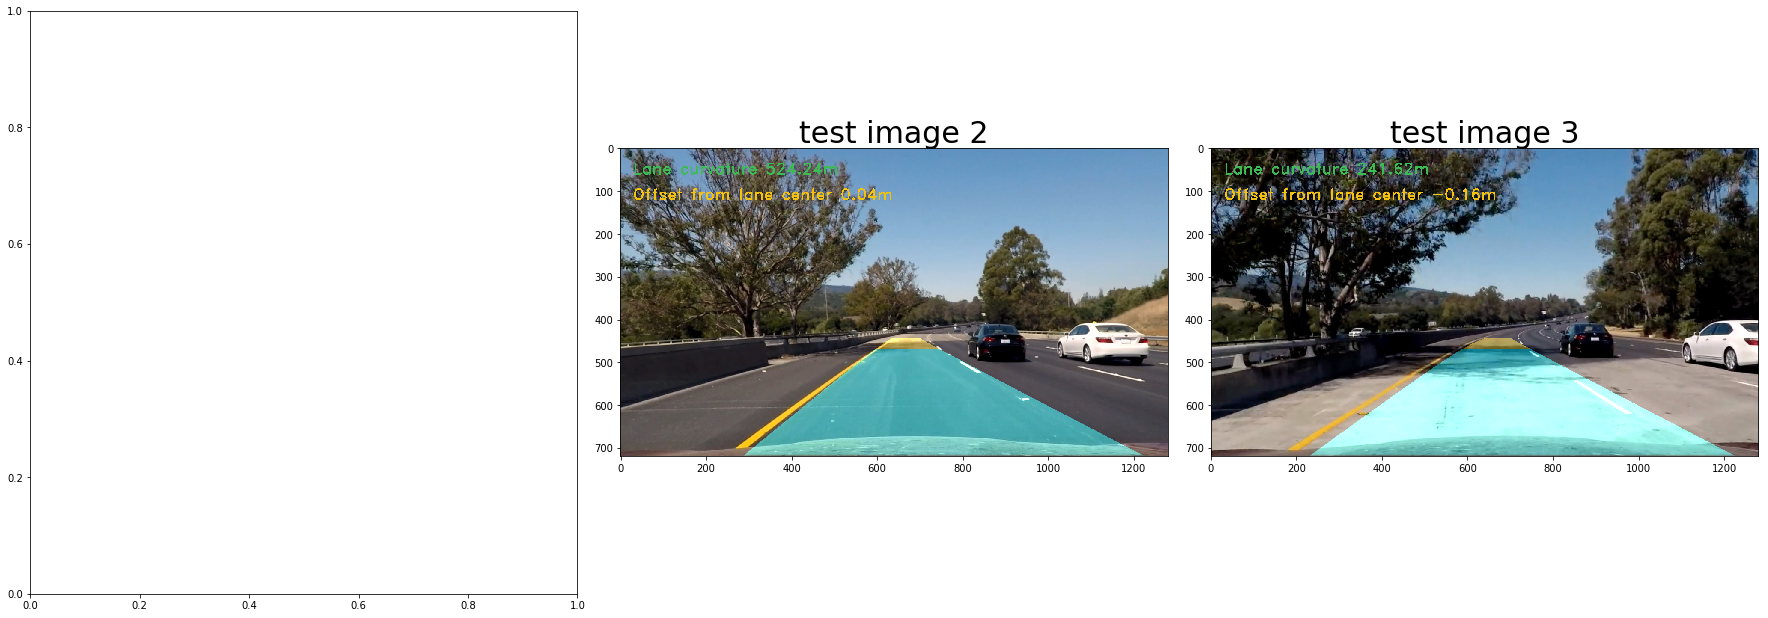

In [44]:
l_line = Line()
r_line = Line()

test_image_final = mpimg.imread('test_images/straight_lines1.jpg')
test_image_final2 = mpimg.imread('test_images/test6.jpg')
test_image_final3 = mpimg.imread('test_images/test5.jpg')
# test = process_image(test_image_final)
test2 = pipeline(test_image_final2)
test3 = pipeline(test_image_final3)
# Plot the result
f, (ax1, ax2, ax3 ) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

# ax1.imshow(test)
# ax1.set_title('test image 1', fontsize=30)

ax2.imshow(test2)
ax2.set_title('test image 2', fontsize=30)

ax3.imshow(test3)
ax3.set_title('test image 3', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

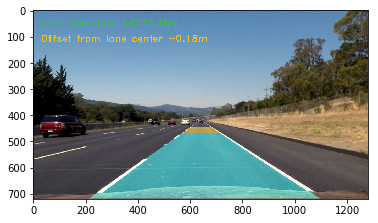

# Test Pipeline on Videos

In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video subclip_out.mp4
[MoviePy] Writing video subclip_out.mp4


100%|█████████▉| 200/201 [04:40<00:01,  1.50s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip_out.mp4 

Wall time: 4min 41s


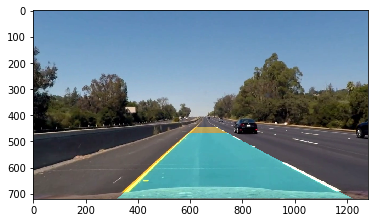

In [38]:
output_vid = 'subclip_out.mp4'
clip1 = VideoFileClip("subclip.mp4")
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(output_vid, audio=False)

# Display Video in Notebook

In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_vid))

# Tests to save images to output_images

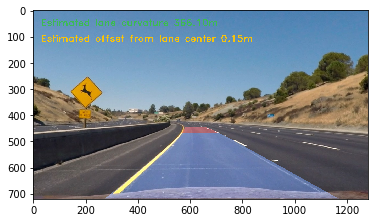

In [22]:
# first Image
initial_img = mpimg.imread('test_images/test2.jpg')
plt.imshow(initial_img)
plt.savefig('output_images/1nitial_img.jpg')

# undistort
undistorted_test, _, _ = cal_undistort(initial_img, objpoints, imgpoints)
plt.imshow(undistorted_test)
plt.savefig('output_images/2undistort.jpg')

# threshold
thresh_test = threshold(undistorted_test)
plt.imshow(thresh_test, cmap = plt.get_cmap('gray'))
plt.savefig('output_images/3threhsold.jpg')

# mask
masked_test = region_of_interest(thresh_test, vertices)
plt.imshow(masked_test, cmap = plt.get_cmap('gray'))
plt.savefig('output_images/4mask.jpg')

# perspective warp
perspective_test = warp(masked_test)
plt.imshow(perspective_test, cmap = plt.get_cmap('gray'))
plt.savefig('output_images/5perspectivewarp.jpg')


# Find lanes
find_lanes_from_tests = find_lanes(perspective_test)
# saved it in function #6


# draw lanes and info
finished_img = pipeline(initial_img)
plt.imshow(finished_img)
plt.savefig('output_images/7finalImage.jpg')




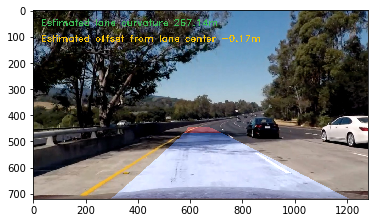

In [27]:
test_img5 = mpimg.imread('test_images/test5.jpg')
# draw lanes and info
finished_img = pipeline(test_img5)
plt.imshow(finished_img)
plt.show()